John Padworski </br>
Week 3 </br>
Micro Project #3

### Problem statement

We aim to understand which demographic and work-related factors are associated with higher income in the Adult Income dataset. Specifically, we will explore how variables such as age, education, occupation, work hours, marital status, and capital gains/losses relate to the probability that an individual’s annual income exceeds $50K. 


### Hypothesis

- H1 (Education): Individuals with higher education-num have a higher probability of income == >50K than those with lower education-num.

    - H0: Mean high-income rate is equal across education levels.

    - HA: Mean high-income rate increases with education level.

- H2 (Work hours): hours-per-week is positively associated with >50K income.

    - H0: Mean hours are equal between <=50K and >50K.

    - HA: Mean hours are higher in the >50K group.

- H3 (Marital status): Being married (e.g., Married-civ-spouse) is associated with a higher >50K rate compared with non-married categories.

    - H0: High-income rate is independent of marital status.

    - HA: High-income rate differs by marital status (expected higher for married).

- H4 (Occupation): occupation groups differ in high-income rates.

    - H0: High-income rate is equal across occupations.

    - HA: At least one occupation has a different high-income rate.

- H5 (Capital gains): Positive capital-gain is associated with higher odds of >50K.

    - H0: High-income rate is independent of having any capital gains.

    - HA: High-income rate is higher when capital-gain > 0.

In [192]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score,GridSearchCV 
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
    confusion_matrix
)
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import mutual_info_score
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import ConfusionMatrixDisplay, RocCurveDisplay



In [143]:
CSV_PATH = r"adult_income.csv"  
df = pd.read_csv(CSV_PATH)

print("Shape:", df.shape)
df.head()


Shape: (32561, 15)


,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,native-country,income
0,39,State-gov,77516,Bachelors,13,Never-married,Adm-clerical,Not-in-family,White,Male,2174,0,40,United-States,<=50K
1,50,Self-emp-not-inc,83311,Bachelors,13,Married-civ-spouse,Exec-managerial,Husband,White,Male,0,0,13,United-States,<=50K
2,38,Private,215646,HS-grad,9,Divorced,Handlers-cleaners,Not-in-family,White,Male,0,0,40,United-States,<=50K
3,53,Private,234721,11th,7,Married-civ-spouse,Handlers-cleaners,Husband,Black,Male,0,0,40,United-States,<=50K
4,28,Private,338409,Bachelors,13,Married-civ-spouse,Prof-specialty,Wife,Black,Female,0,0,40,Cuba,<=50K


In [144]:
df.info()

#Numeric summary
df.describe(include=[np.number])

#Categorical peek: top categories for a few columns
cat_cols = df.select_dtypes(include=["object"]).columns.tolist()
{c: df[c].value_counts().head(5) for c in cat_cols[:8]}


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32561 entries, 0 to 32560
Data columns (total 15 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age             32561 non-null  int64 
 1   workclass       32561 non-null  object
 2   fnlwgt          32561 non-null  int64 
 3   education       32561 non-null  object
 4   education-num   32561 non-null  int64 
 5   marital-status  32561 non-null  object
 6   occupation      32561 non-null  object
 7   relationship    32561 non-null  object
 8   race            32561 non-null  object
 9   sex             32561 non-null  object
 10  capital-gain    32561 non-null  int64 
 11  capital-loss    32561 non-null  int64 
 12  hours-per-week  32561 non-null  int64 
 13  native-country  32561 non-null  object
 14  income          32561 non-null  object
dtypes: int64(6), object(9)
memory usage: 3.7+ MB


{'workclass': workclass
 Private             22696
 Self-emp-not-inc     2541
 Local-gov            2093
 ?                    1836
 State-gov            1298
 Name: count, dtype: int64,
 'education': education
 HS-grad         10501
 Some-college     7291
 Bachelors        5355
 Masters          1723
 Assoc-voc        1382
 Name: count, dtype: int64,
 'marital-status': marital-status
 Married-civ-spouse    14976
 Never-married         10683
 Divorced               4443
 Separated              1025
 Widowed                 993
 Name: count, dtype: int64,
 'occupation': occupation
 Prof-specialty     4140
 Craft-repair       4099
 Exec-managerial    4066
 Adm-clerical       3770
 Sales              3650
 Name: count, dtype: int64,
 'relationship': relationship
 Husband          13193
 Not-in-family     8305
 Own-child         5068
 Unmarried         3446
 Wife              1568
 Name: count, dtype: int64,
 'race': race
 White                 27816
 Black                  3124
 Asian-Pac

In [145]:
#Replace '?' with NaN in object columns
df_clean = df.replace('?', np.nan).copy()

#Basic missingness overview
df_clean.isna().sum().sort_values(ascending=False).head(15)




occupation        1843
workclass         1836
native-country     583
age                  0
fnlwgt               0
education            0
education-num        0
marital-status       0
relationship         0
race                 0
sex                  0
capital-gain         0
capital-loss         0
hours-per-week       0
income               0
dtype: int64

In [146]:
#Simple imputation strategy:
#Categorical: fill missing with mode
#Numeric: fill missing with median 
for c in df_clean.columns:
    if pd.api.types.is_numeric_dtype(df_clean[c]):
        if df_clean[c].isna().any():
            df_clean[c] = df_clean[c].fillna(df_clean[c].median())
    else:
        mode_val = df_clean[c].mode(dropna=True)
        if not mode_val.empty:
            df_clean[c] = df_clean[c].fillna(mode_val.iloc[0])
        else:
            df_clean[c] = df_clean[c].fillna("Missing")

df_clean.isna().sum().sort_values(ascending=False).head(10)



age               0
workclass         0
fnlwgt            0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
dtype: int64

In [147]:
#Drop exact duplicate rows
before = len(df_clean)
df_clean = df_clean.drop_duplicates()
after = len(df_clean)
print(f"Removed {before - after} duplicate rows. New shape: {df_clean.shape}")


Removed 24 duplicate rows. New shape: (32537, 15)


In [148]:
#Target: high_income (1 if >50K else 0)
df_feat = df_clean.copy()
df_feat["high_income"] = (df_feat["income"].str.strip() == ">50K").astype(int)

#Binary flags useful for analysis
df_feat["any_capital_gain"] = (df_feat["capital-gain"] > 0).astype(int)
df_feat["any_capital_loss"] = (df_feat["capital-loss"] > 0).astype(int)

#An example of grouping education levels via education-num (already numeric years-of-education proxy)
#Also create a tidy label for plotting
df_feat["education_num_label"] = df_feat["education-num"].astype(int).astype(str)

df_feat[["education","education-num","hours-per-week","income","high_income","any_capital_gain"]].head()


,education,education-num,hours-per-week,income,high_income,any_capital_gain
0,Bachelors,13,40,<=50K,0,1
1,Bachelors,13,13,<=50K,0,0
2,HS-grad,9,40,<=50K,0,0
3,11th,7,40,<=50K,0,0
4,Bachelors,13,40,<=50K,0,0


In [149]:
#IQR capping for highly skewed numerics (capital-gain, capital-loss, hours-per-week)
def iqr_cap(series):
    q1, q3 = series.quantile([0.25, 0.75])
    iqr = q3 - q1
    low, high = q1 - 1.5*iqr, q3 + 1.5*iqr
    return series.clip(lower=low, upper=high)

for col in ["capital-gain", "capital-loss", "hours-per-week"]:
    if col in df_feat.columns and pd.api.types.is_numeric_dtype(df_feat[col]):
        df_feat[col + "_capped"] = iqr_cap(df_feat[col])

caps = [c for c in df_feat.columns if c.endswith("_capped")]
df_feat[caps].describe() if caps else "No caps created."


,capital-gain_capped,capital-loss_capped,hours-per-week_capped
count,32537.0,32537.0,32537.000000
mean,0.0,0.0,41.203246
std,0.0,0.0,6.187352
min,0.0,0.0,32.500000
25%,0.0,0.0,40.000000
50%,0.0,0.0,40.000000
75%,0.0,0.0,45.000000
max,0.0,0.0,52.500000


In [150]:
#High-income rate by education level
edu_rate = (df_feat.groupby("education-num")["high_income"]
            .mean()
            .sort_index())
edu_rate.head(10), edu_rate.tail(10)


(education-num
 1     0.000000
 2     0.036145
 3     0.048193
 4     0.062016
 5     0.052529
 6     0.066452
 7     0.051064
 8     0.076212
 9     0.159520
 10    0.190332
 Name: high_income, dtype: float64,
 education-num
 7     0.051064
 8     0.076212
 9     0.159520
 10    0.190332
 11    0.261216
 12    0.248360
 13    0.414908
 14    0.556911
 15    0.734375
 16    0.740920
 Name: high_income, dtype: float64)

In [151]:
#High-income rate by marital status
ms_rate = df_feat.groupby("marital-status")["high_income"].mean().sort_values(ascending=False)
ms_rate.head(10)


marital-status
Married-civ-spouse       0.446894
Married-AF-spouse        0.434783
Divorced                 0.104256
Widowed                  0.085599
Married-spouse-absent    0.081340
Separated                0.064390
Never-married            0.046030
Name: high_income, dtype: float64

In [152]:
#High-income rate by occupation
occ_rate = df_feat.groupby("occupation")["high_income"].mean().sort_values(ascending=False)
occ_rate.head(10)


occupation
Exec-managerial      0.484133
Prof-specialty       0.342699
Protective-serv      0.325116
Tech-support         0.305286
Sales                0.269315
Craft-repair         0.226917
Transport-moving     0.200376
Adm-clerical         0.134554
Machine-op-inspct    0.124500
Farming-fishing      0.115927
Name: high_income, dtype: float64

In [153]:
#Average hours-per-week by income group
df_feat.groupby("income")["hours-per-week"].mean().sort_values(ascending=False)


income
>50K     45.473402
<=50K    38.842862
Name: hours-per-week, dtype: float64

In [154]:
#Cross-tab: occupation × (high_income rate)
pivot_occ_edu = pd.pivot_table(
    df_feat,
    values="high_income",
    index="occupation",
    columns="education",
    aggfunc="mean"
)
pivot_occ_edu.round(3).head(10)


education,10th,11th,12th,1st-4th,5th-6th,7th-8th,9th,Assoc-acdm,Assoc-voc,Bachelors,Doctorate,HS-grad,Masters,Preschool,Prof-school,Some-college
occupation,,,,,,,,,,,,,,,,
Adm-clerical,0.000,0.045,0.026,NaN,0.000,0.091,0.071,0.155,0.108,0.235,0.400,0.119,0.338,0.0,0.444,0.111
Armed-Forces,NaN,NaN,0.000,NaN,NaN,NaN,NaN,NaN,NaN,0.000,NaN,0.000,1.000,NaN,NaN,0.000
Craft-repair,0.112,0.103,0.155,0.087,0.070,0.070,0.073,0.278,0.321,0.391,0.500,0.211,0.455,0.0,0.714,0.278
Exec-managerial,0.250,0.206,0.154,0.500,1.000,0.316,0.154,0.455,0.427,0.569,0.909,0.323,0.743,NaN,0.731,0.355
Farming-fishing,0.023,0.054,0.000,0.056,0.000,0.071,0.036,0.214,0.173,0.273,1.000,0.117,0.300,0.0,0.250,0.115
Handlers-cleaners,0.028,0.041,0.053,0.000,0.051,0.000,0.061,0.083,0.071,0.220,NaN,0.062,0.000,0.0,NaN,0.071
Machine-op-inspct,0.059,0.030,0.029,0.043,0.054,0.065,0.039,0.273,0.222,0.261,1.000,0.136,0.125,0.0,0.000,0.142
Other-service,0.005,0.025,0.012,0.000,0.000,0.010,0.020,0.077,0.078,0.160,1.000,0.041,0.053,0.0,0.250,0.033
Priv-house-serv,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.143,NaN,0.000,0.000,0.0,NaN,0.000


I sorted by education-num because it represents the natural progression of education levels. This makes it easier to observe trends in high-income rates across increasing education levels and directly supports testing our hypothesis about the relationship between education and income.

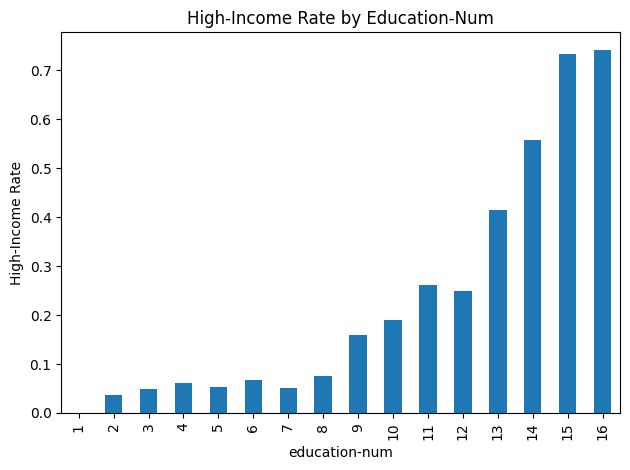

In [155]:
#High-income rate by education-num (ordered)
plt.figure()
edu_rate.plot(kind="bar", title="High-Income Rate by Education-Num")
plt.xlabel("education-num")
plt.ylabel("High-Income Rate")
plt.tight_layout()
plt.show()


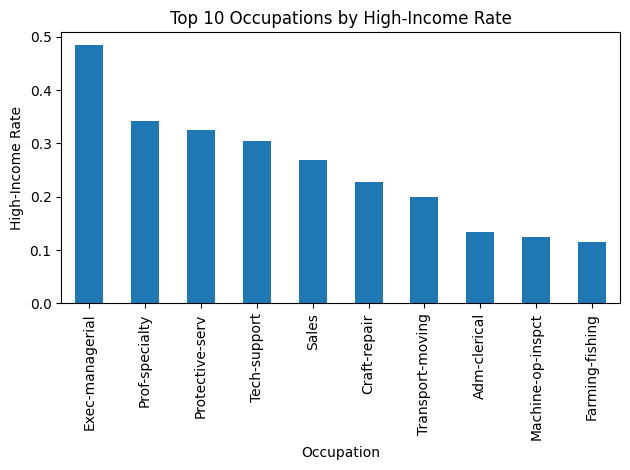

In [156]:
#Top 10 occupations by high-income rate (drop NaNs)
top_occ = occ_rate.dropna().head(10)
plt.figure()
top_occ.plot(kind="bar", title="Top 10 Occupations by High-Income Rate")
plt.xlabel("Occupation")
plt.ylabel("High-Income Rate")
plt.tight_layout()
plt.show()


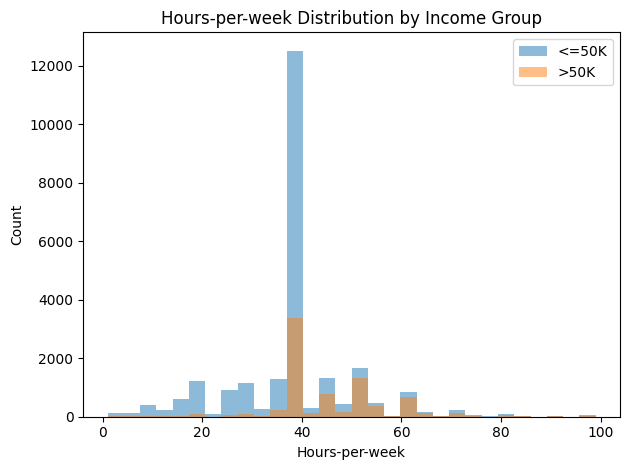

In [157]:
#Hours-per-week distribution by income group (simple overlaid histograms)
plt.figure()
for label, g in df_feat.groupby("income"):
    g["hours-per-week"].plot(kind="hist", alpha=0.5, bins=30, label=label)
plt.title("Hours-per-week Distribution by Income Group")
plt.xlabel("Hours-per-week")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()
plt.show()


In [158]:
from scipy import stats

#H2: t-test on hours-per-week between <=50K and >50K
g0 = df_feat.loc[df_feat["high_income"] == 0, "hours-per-week"].dropna()
g1 = df_feat.loc[df_feat["high_income"] == 1, "hours-per-week"].dropna()

tstat, pval = stats.ttest_ind(g1, g0, equal_var=False)
print(f"H2 t-test (hours-per-week): t={tstat:.3f}, p={pval:.3g} (n>50K={len(g1)}, n<=50K={len(g0)})")


H2 t-test (hours-per-week): t=45.095, p=0 (n>50K=7839, n<=50K=24698)


In [159]:
#H3: Chi-square test of independence for marital-status vs high_income
ct_ms = pd.crosstab(df_feat["marital-status"], df_feat["high_income"])
chi2, p, dof, exp = stats.chi2_contingency(ct_ms)
print("H3 Chi-square (marital-status ~ high_income):")
print(f"chi2={chi2:.3f}, dof={dof}, p={p:.3g}")
ct_ms.head()


H3 Chi-square (marital-status ~ high_income):
chi2=6510.332, dof=6, p=0


high_income,0,1
marital-status,,
Divorced,3978,463
Married-AF-spouse,13,10
Married-civ-spouse,8280,6690
Married-spouse-absent,384,34
Never-married,10176,491


In [160]:
#H4: Chi-square test for occupation vs high_income
ct_occ = pd.crosstab(df_feat["occupation"], df_feat["high_income"])
chi2, p, dof, exp = stats.chi2_contingency(ct_occ)
print("H4 Chi-square (occupation ~ high_income):")
print(f"chi2={chi2:.3f}, dof={dof}, p={p:.3g}")
ct_occ.head()


H4 Chi-square (occupation ~ high_income):
chi2=3197.613, dof=13, p=0


high_income,0,1
occupation,,
Adm-clerical,3261,507
Armed-Forces,8,1
Craft-repair,3165,929
Exec-managerial,2097,1968
Farming-fishing,877,115


In [161]:
#H5: Chi-square for any capital gain vs high_income
ct_gain = pd.crosstab(df_feat["any_capital_gain"], df_feat["high_income"])
chi2, p, dof, exp = stats.chi2_contingency(ct_gain)
print("H5 Chi-square (any_capital_gain ~ high_income):")
print(f"chi2={chi2:.3f}, dof={dof}, p={p:.3g}")
ct_gain


H5 Chi-square (any_capital_gain ~ high_income):
chi2=2302.418, dof=1, p=0


high_income,0,1
any_capital_gain,,
0,23663,6162
1,1035,1677


In [162]:
TARGET = "high_income"
def show_title(t):
    print("\n" + "="*len(t) + f"\n{t}\n" + "="*len(t))

show_title("Data Quality Summary")

dq = []
for c in df_feat.columns:
    miss = df_feat[c].isna().mean()
    nunique = df_feat[c].nunique(dropna=True)
    dtype = df_feat[c].dtype
    coltype = ("numeric" if pd.api.types.is_numeric_dtype(df_feat[c]) else "categorical")
    dq.append({"column": c, "dtype": str(dtype), "type": coltype, "missing_rate": miss, "nunique": nunique})
dq = pd.DataFrame(dq).sort_values(["type","missing_rate","nunique"], ascending=[True, False, False])
dq



Data Quality Summary


,column,dtype,type,missing_rate,nunique
13,native-country,object,categorical,0.0,41
3,education,object,categorical,0.0,16
18,education_num_label,object,categorical,0.0,16
6,occupation,object,categorical,0.0,14
1,workclass,object,categorical,0.0,8
5,marital-status,object,categorical,0.0,7
7,relationship,object,categorical,0.0,6
8,race,object,categorical,0.0,5
9,sex,object,categorical,0.0,2
14,income,object,categorical,0.0,2


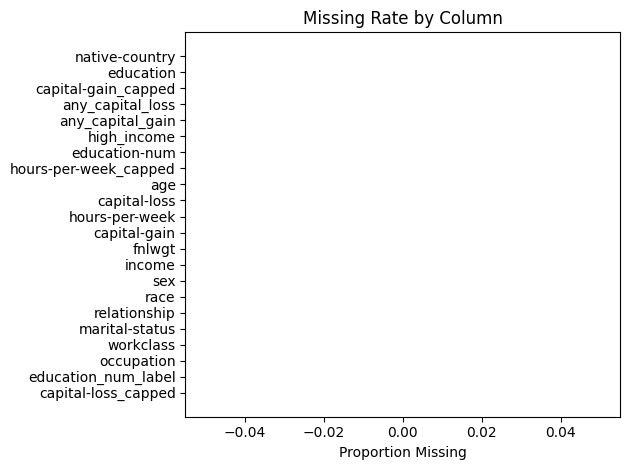

In [163]:
#Missingness
top_miss = dq.sort_values("missing_rate", ascending=False).head(25)
plt.figure()
plt.barh(top_miss["column"][::-1], top_miss["missing_rate"][::-1])
plt.title("Missing Rate by Column")
plt.xlabel("Proportion Missing")
plt.tight_layout(); plt.show()



Univariate Numeric Distributions (with target overlays)


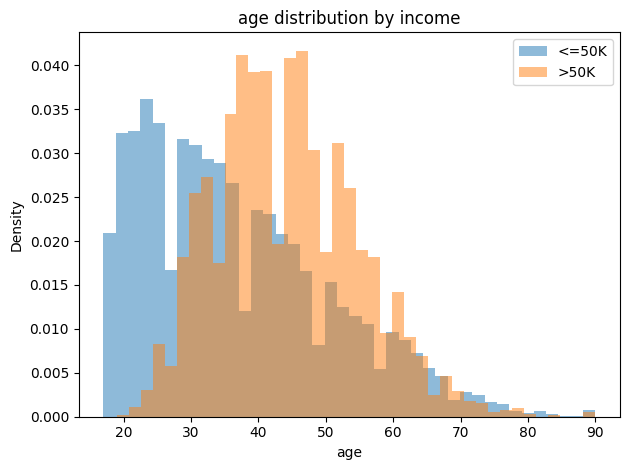

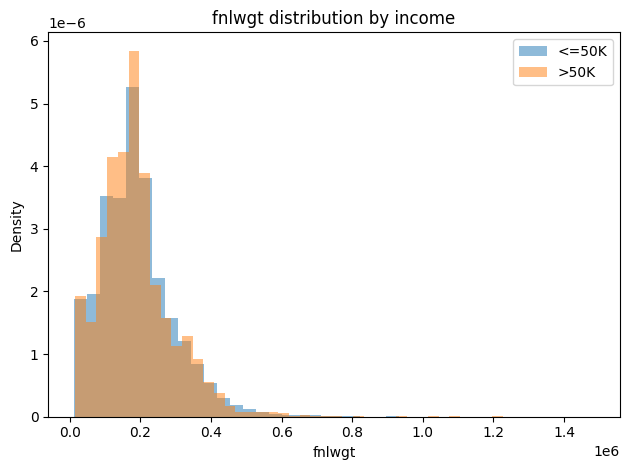

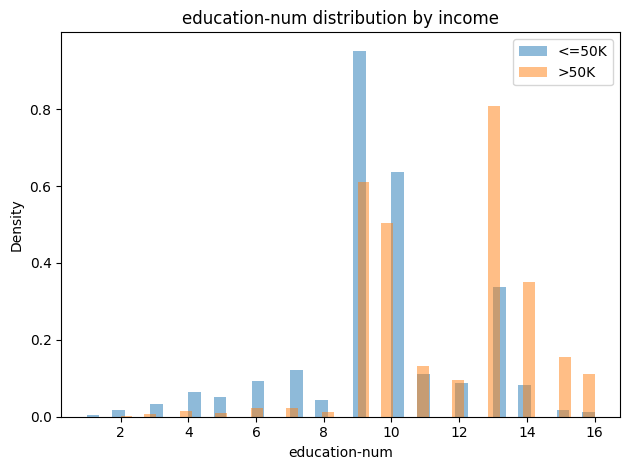

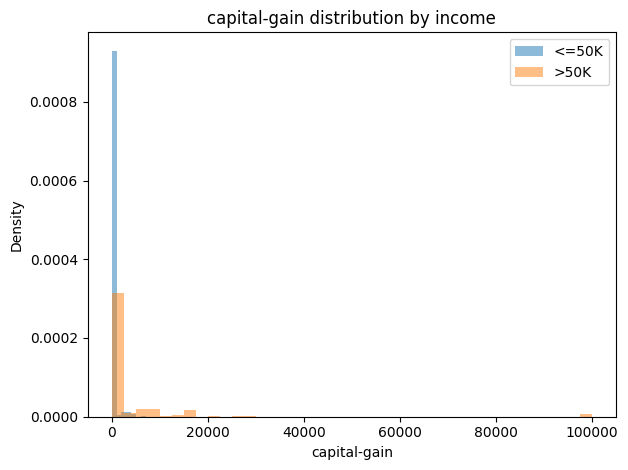

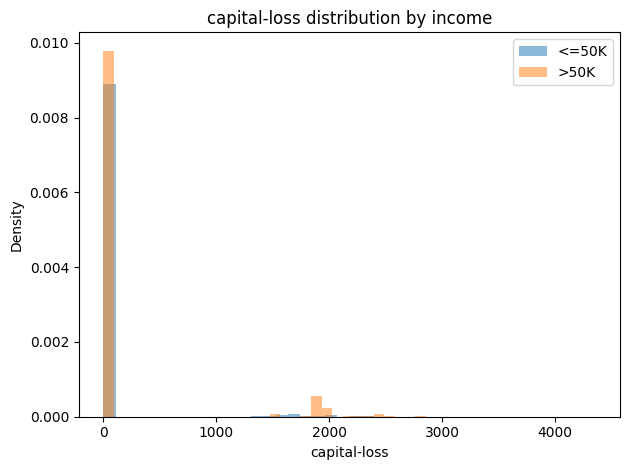

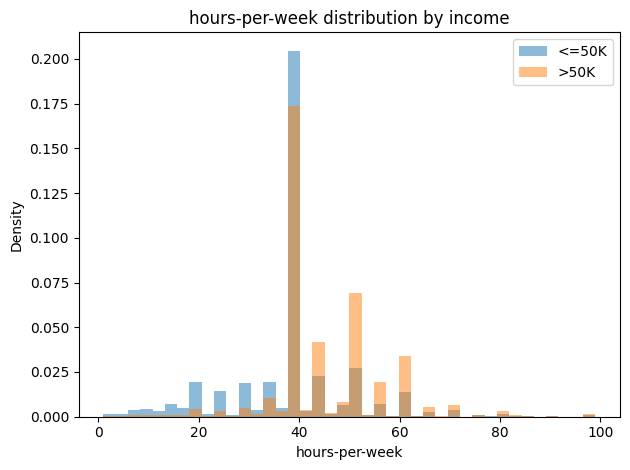

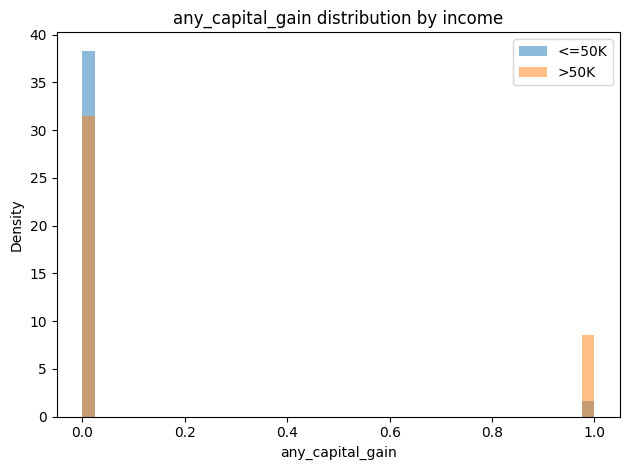

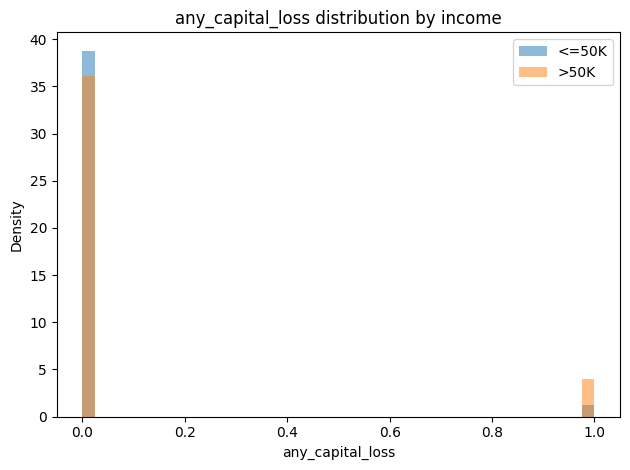

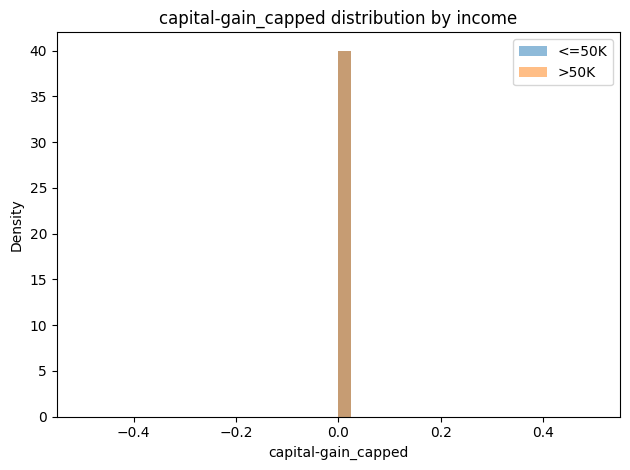

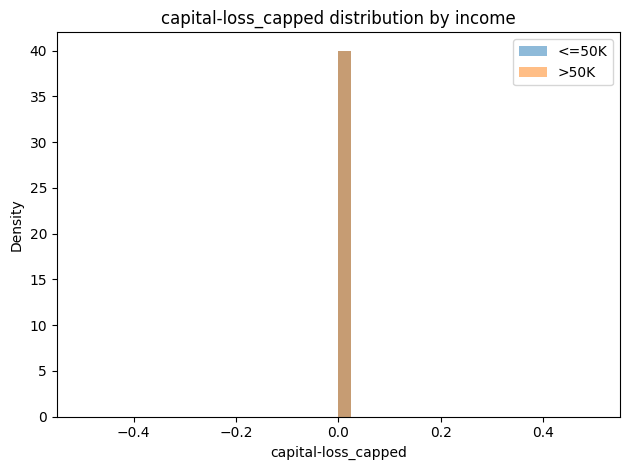

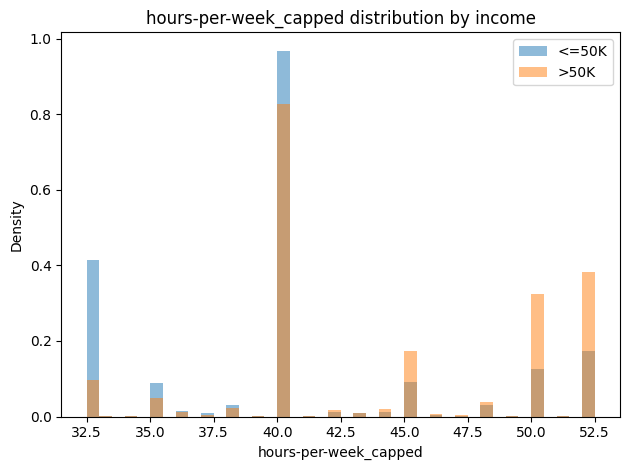

In [164]:
show_title("Univariate Numeric Distributions (with target overlays)")
num_cols = [c for c in df_feat.select_dtypes(include=[np.number]).columns if c != TARGET]

for c in num_cols:
    plt.figure()
    a = df_feat.loc[df_feat[TARGET]==0, c].dropna()
    b = df_feat.loc[df_feat[TARGET]==1, c].dropna()
    plt.hist(a, bins=40, alpha=0.5, label="<=50K", density=True)
    plt.hist(b, bins=40, alpha=0.5, label=">50K", density=True)
    plt.title(f"{c} distribution by income")
    plt.xlabel(c); plt.ylabel("Density"); plt.legend(); plt.tight_layout(); plt.show()



Numeric Correlations (Spearman)


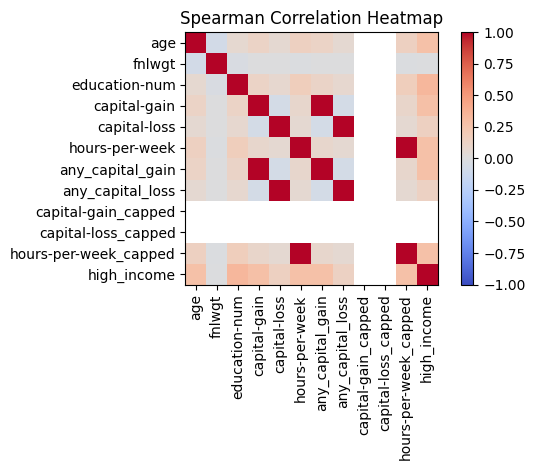

In [165]:
show_title("Numeric Correlations (Spearman)")
num_df = df_feat[num_cols + [TARGET]].copy()
corr = num_df.corr(method="spearman")
plt.figure()
plt.imshow(corr, cmap="coolwarm", vmin=-1, vmax=1)
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
plt.yticks(range(len(corr.index)), corr.index)
plt.colorbar(); plt.title("Spearman Correlation Heatmap")
plt.tight_layout(); plt.show()




In [166]:
show_title("Target-Aware Feature Screening")

X_screen = df_feat[num_cols + cat_cols].copy()
y_screen = df_feat[TARGET].astype(int).values

X_ohe_df = pd.get_dummies(X_screen[cat_cols], dummy_na=False)
X_mi_df = pd.concat([X_screen[num_cols].reset_index(drop=True), X_ohe_df.reset_index(drop=True)], axis=1)

discrete_mask = np.array([False] * len(num_cols) + [True] * X_ohe_df.shape[1])

mi = mutual_info_classif(X_mi_df.values, y_screen, discrete_features=discrete_mask, random_state=42)
mi_series = pd.Series(mi, index=list(X_mi_df.columns)).sort_values(ascending=False)
mi_series.head(25)


Target-Aware Feature Screening


income_>50K                          0.552145
income_<=50K                         0.552145
marital-status_Married-civ-spouse    0.105396
capital-gain                         0.081535
relationship_Husband                 0.080843
age                                  0.069509
education-num                        0.066710
marital-status_Never-married         0.061888
hours-per-week                       0.042381
hours-per-week_capped                0.039446
relationship_Own-child               0.038234
capital-loss                         0.033343
fnlwgt                               0.032451
any_capital_gain                     0.028103
sex_Male                             0.025761
sex_Female                           0.025761
occupation_Exec-managerial           0.020305
relationship_Not-in-family           0.020138
occupation_Other-service             0.016418
education_Bachelors                  0.014821
relationship_Unmarried               0.012960
education_Masters                 

In [167]:
show_title("Consolidate Rare Levels (<1% each)")

def collapse_rare_levels(df, cols, min_freq=0.01, other_label="Other"):
    df2 = df.copy()
    n = len(df2)
    for c in cols:
        vc = df2[c].value_counts(dropna=False) / n
        rare = vc[vc < min_freq].index
        if len(rare) > 0:
            df2[c] = df2[c].where(~df2[c].isin(rare), other_label)
    return df2

df_feat2 = collapse_rare_levels(df_feat, cat_cols, min_freq=0.01)
for c in cat_cols[:5]:
    display(df_feat[c].value_counts().head(5), df_feat2[c].value_counts().head(5))



Consolidate Rare Levels (<1% each)


workclass
Private             24509
Self-emp-not-inc     2540
Local-gov            2093
State-gov            1298
Self-emp-inc         1116
Name: count, dtype: int64

workclass
Private             24509
Self-emp-not-inc     2540
Local-gov            2093
State-gov            1298
Self-emp-inc         1116
Name: count, dtype: int64

education
HS-grad         10494
Some-college     7282
Bachelors        5353
Masters          1722
Assoc-voc        1382
Name: count, dtype: int64

education
HS-grad         10494
Some-college     7282
Bachelors        5353
Masters          1722
Assoc-voc        1382
Name: count, dtype: int64

marital-status
Married-civ-spouse    14970
Never-married         10667
Divorced               4441
Separated              1025
Widowed                 993
Name: count, dtype: int64

marital-status
Married-civ-spouse    14970
Never-married         10667
Divorced               4441
Separated              1025
Widowed                 993
Name: count, dtype: int64

occupation
Prof-specialty     5979
Craft-repair       4094
Exec-managerial    4065
Adm-clerical       3768
Sales              3650
Name: count, dtype: int64

occupation
Prof-specialty     5979
Craft-repair       4094
Exec-managerial    4065
Adm-clerical       3768
Sales              3650
Name: count, dtype: int64

relationship
Husband          13187
Not-in-family     8292
Own-child         5064
Unmarried         3445
Wife              1568
Name: count, dtype: int64

relationship
Husband          13187
Not-in-family     8292
Own-child         5064
Unmarried         3445
Wife              1568
Name: count, dtype: int64


Domain Grouping: native-country -> region


,rate,count
country_region,,
NorthAmerica,0.241917,30374
OtherRegion,0.227000,2163


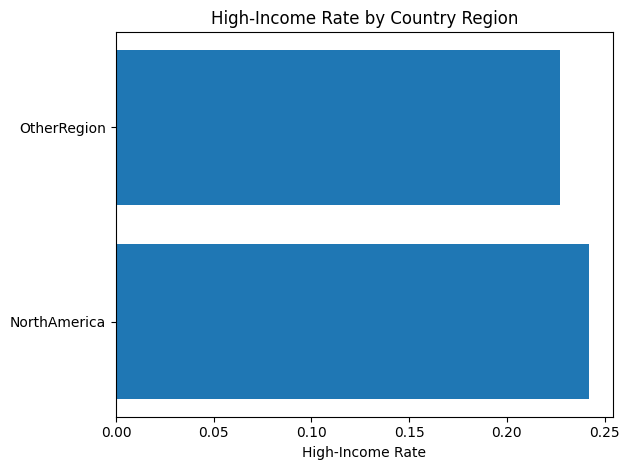

In [168]:
show_title("Domain Grouping: native-country -> region")
if "native-country" in df_feat2.columns:
    region_map = {
        "United-States": "NorthAmerica", "Canada": "NorthAmerica", "Mexico": "NorthAmerica",
        "India": "Asia", "China": "Asia", "Japan": "Asia", "Philippines": "Asia", "Vietnam": "Asia",
        "England": "Europe", "Germany": "Europe", "Italy": "Europe", "France": "Europe",
    }
    df_feat2["country_region"] = df_feat2["native-country"].map(region_map).fillna("OtherRegion")
    g = df_feat2.groupby("country_region")[TARGET].agg(rate="mean", count="size").sort_values("rate", ascending=False)
    display(g)

    plt.figure()
    plt.barh(g.index, g["rate"])
    plt.title("High-Income Rate by Country Region")
    plt.xlabel("High-Income Rate"); plt.tight_layout(); plt.show()



Numeric Binning for Reporting


C:\Users\john_\AppData\Local\Temp\ipykernel_30856\1364732681.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t = df_feat2.groupby(qs)[TARGET].mean()


age
(16.999, 26.0]    0.024635
(26.0, 33.0]      0.179074
(33.0, 41.0]      0.313757
(41.0, 50.0]      0.384989
(50.0, 90.0]      0.324818
Name: high_income, dtype: float64

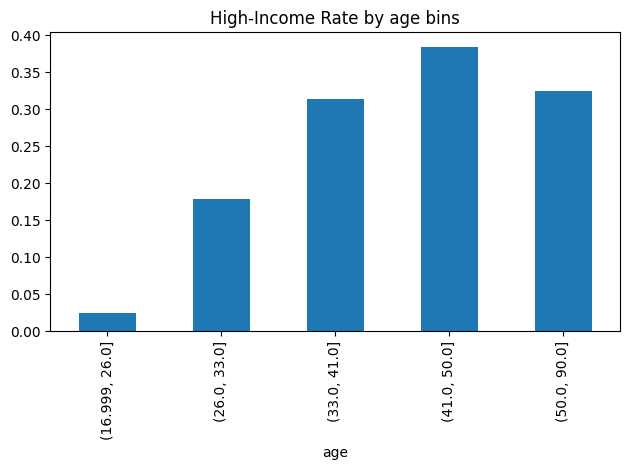

C:\Users\john_\AppData\Local\Temp\ipykernel_30856\1364732681.py:4: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  t = df_feat2.groupby(qs)[TARGET].mean()


hours-per-week
(0.999, 35.0]    0.084667
(35.0, 40.0]     0.211475
(40.0, 48.0]     0.346179
(48.0, 99.0]     0.429408
Name: high_income, dtype: float64

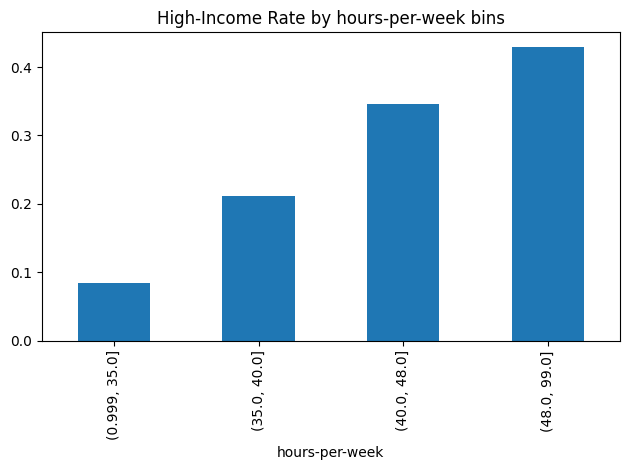

In [169]:
show_title("Numeric Binning for Reporting")
def bin_numeric(col, q=5, labels=None):
    qs = pd.qcut(df_feat2[col], q=q, duplicates="drop", labels=labels)
    t = df_feat2.groupby(qs)[TARGET].mean()
    display(t)
    plt.figure(); t.plot(kind="bar"); plt.title(f"High-Income Rate by {col} bins"); plt.tight_layout(); plt.show()
    return qs

if "age" in df_feat2: df_feat2["age_bin"] = bin_numeric("age", q=5)
if "hours-per-week" in df_feat2: df_feat2["hours_bin"] = bin_numeric("hours-per-week", q=5)


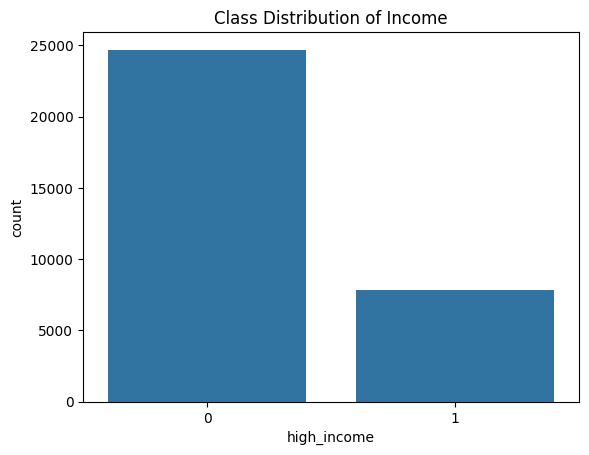

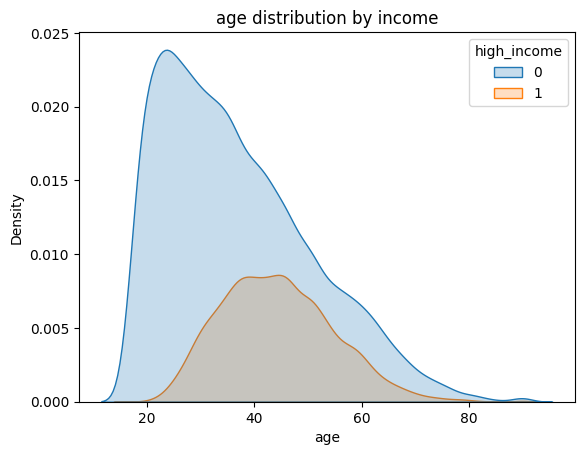

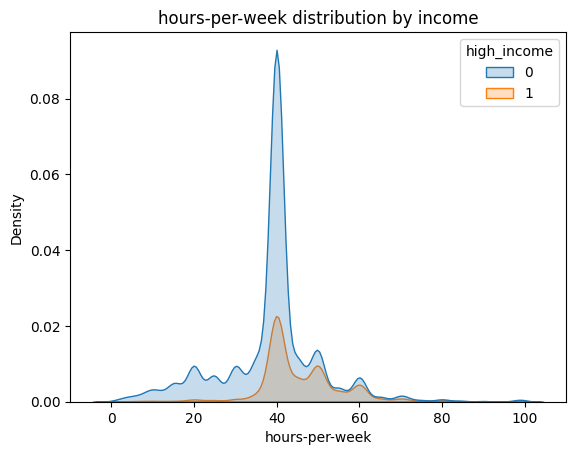

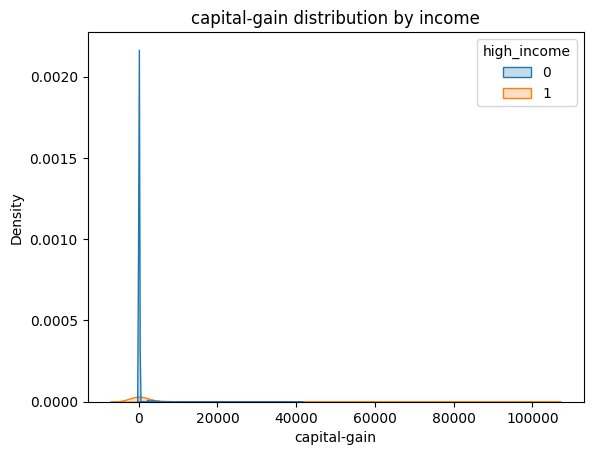

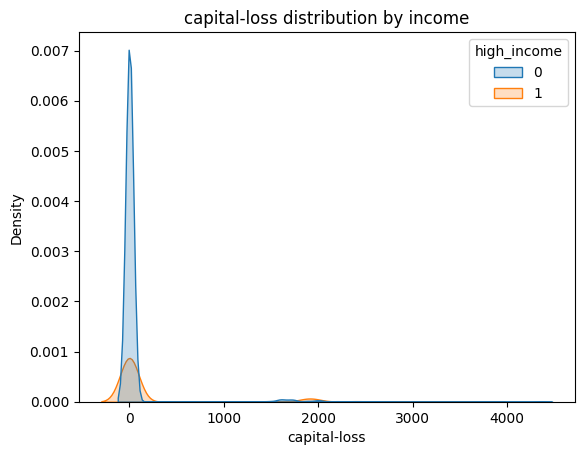

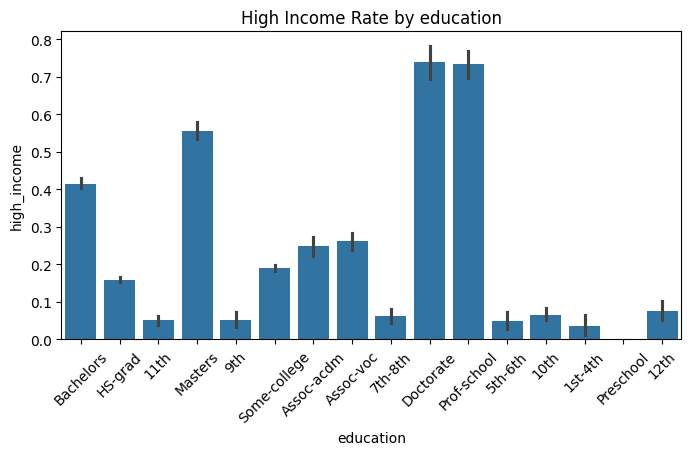

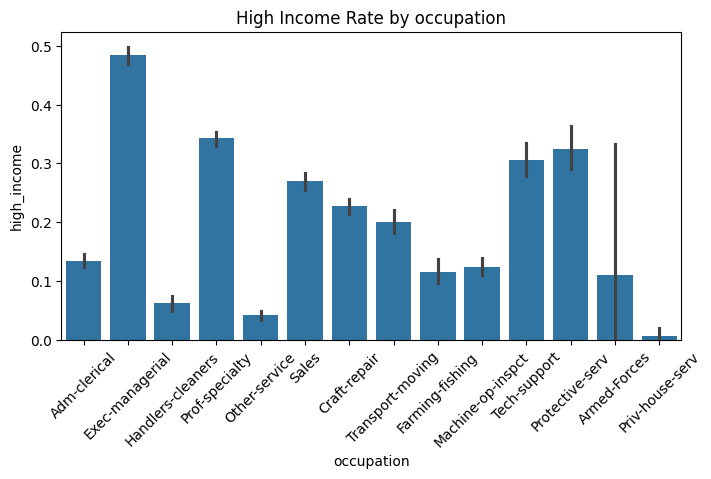

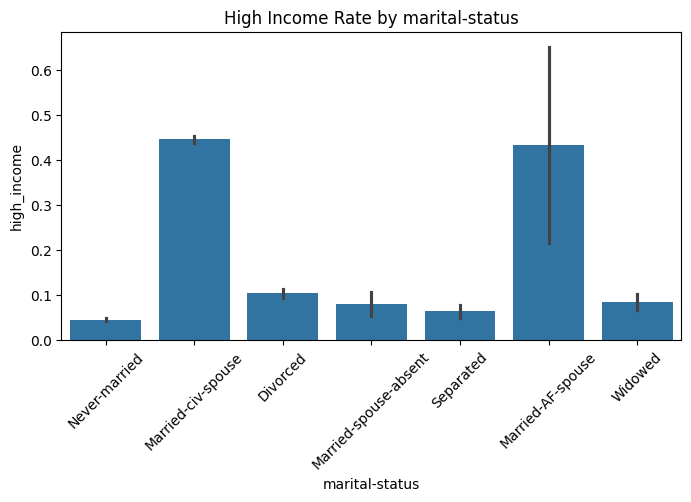

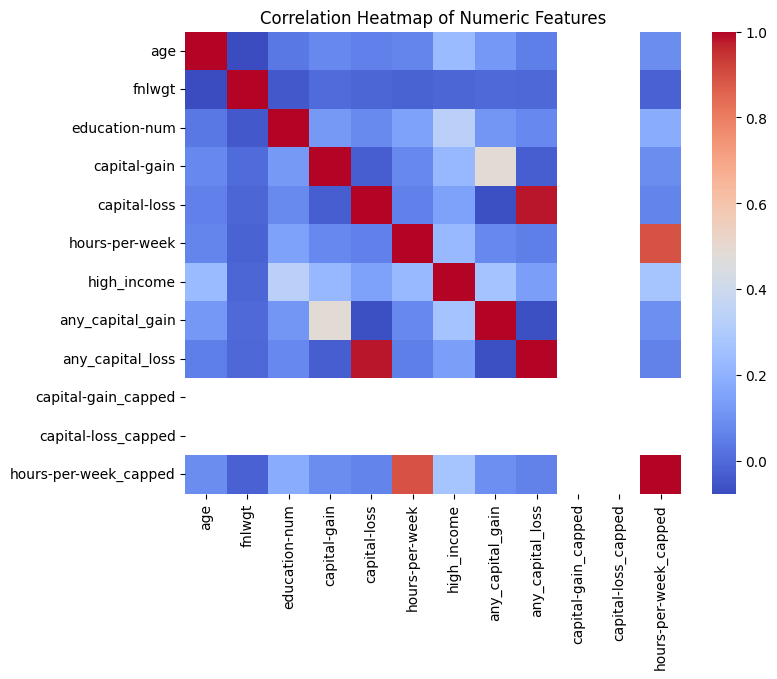

In [170]:
# Income balance
sns.countplot(x='high_income', data=df_feat)
plt.title('Class Distribution of Income')
plt.show()

# Numeric feature distribution
numeric_features = ['age', 'hours-per-week', 'capital-gain', 'capital-loss']
for col in numeric_features:
    sns.kdeplot(data=df_feat, x=col, hue='high_income', fill=True)
    plt.title(f'{col} distribution by income')
    plt.show()

# Categorical analysis
cat_features = ['education', 'occupation', 'marital-status']
for col in cat_features:
    plt.figure(figsize=(8,4))
    sns.barplot(data=df_feat, x=col, y='high_income')
    plt.title(f'High Income Rate by {col}')
    plt.xticks(rotation=45)
    plt.show()

# Correlation heatmap
plt.figure(figsize=(8,6))
sns.heatmap(df_feat.corr(numeric_only=True), cmap='coolwarm', annot=False)
plt.title('Correlation Heatmap of Numeric Features')
plt.show()


In [171]:

#target
y = df_feat["high_income"].astype(int)

#features
num_candidates = ["age", "education-num", "hours-per-week", "capital-gain", "capital-loss"]
cat_candidates = ["workclass", "marital-status", "occupation", "relationship", "race", "sex", "native-country", "education"]

num_features = [c for c in num_candidates if c in df_feat.columns]
cat_features = [c for c in cat_candidates if c in df_feat.columns]

X = df_feat[num_features + cat_features].copy()


X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

numeric_pipe = Pipeline(steps=[
    ("scaler", StandardScaler())
])

categorical_pipe = Pipeline(steps=[
    ("onehot", OneHotEncoder(handle_unknown="ignore", sparse_output=False))
])

preprocess = ColumnTransformer(
    transformers=[
        ("num", numeric_pipe, num_features),
        ("cat", categorical_pipe, cat_features),
    ]
)

print("Train class balance (>%50K rate):", round(float(y_train.mean()), 3))
print("Test  class balance (>%50K rate):", round(float(y_test.mean()), 3))


Train class balance (>%50K rate): 0.241
Test  class balance (>%50K rate): 0.241


#### Baseline model

In [172]:
baseline = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", DummyClassifier(strategy="most_frequent"))
])
baseline.fit(X_train, y_train)
y_pred_base = baseline.predict(X_test)
y_prob_base = np.full_like(y_test, fill_value=y_train.mean(), dtype=float)  # flat probs

def metric_summary(y_true, y_pred, y_prob):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_true, y_prob) if len(np.unique(y_true))>1 else np.nan,
        "pr_auc": average_precision_score(y_true, y_prob)
    }

base_metrics = metric_summary(y_test, y_pred_base, y_prob_base)
pd.DataFrame([base_metrics], index=["Baseline"])


,accuracy,precision,recall,f1,roc_auc,pr_auc
Baseline,0.759066,0.0,0.0,0.0,0.5,0.240934


#### Logistic Regression

In [173]:
log_reg = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", LogisticRegression(
        max_iter=2000, solver="liblinear", class_weight="balanced"  # handles imbalance
    ))
])
log_reg.fit(X_train, y_train)

y_pred_lr = log_reg.predict(X_test)
y_prob_lr = log_reg.predict_proba(X_test)[:, 1]

lr_metrics = metric_summary(y_test, y_pred_lr, y_prob_lr)
pd.DataFrame([base_metrics, lr_metrics], index=["Baseline","LogisticRegression"]).round(3)


,accuracy,precision,recall,f1,roc_auc,pr_auc
Baseline,0.759,0.000,0.000,0.000,0.50,0.241
LogisticRegression,0.809,0.568,0.858,0.684,0.91,0.773


#### SVM

In [174]:
y = df_feat["high_income"].astype(int).values
num_cols = [c for c in ["age","education-num","hours-per-week","capital-gain","capital-loss"] if c in df_feat.columns]
cat_cols = [c for c in ["workclass","marital-status","occupation","relationship","race","sex","native-country","education"] if c in df_feat.columns]

X = df_feat[num_cols + cat_cols].copy()

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42, stratify=y
)

preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
], remainder="drop")


In [175]:
svm_linear = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", SVC(kernel="linear", probability=True, random_state=42))
])

#RBF SVM
svm_rbf = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", SVC(kernel="rbf", probability=True, random_state=42))
])

#Fit both
svm_linear.fit(X_train, y_train)
svm_rbf.fit(X_train, y_train)


,steps,"[('prep', ...), ('clf', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...), ('cat', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


In [176]:
def metric_summary(y_true, y_pred, y_prob):
    return {
        "accuracy": accuracy_score(y_true, y_pred),
        "precision": precision_score(y_true, y_pred, zero_division=0),
        "recall": recall_score(y_true, y_pred, zero_division=0),
        "f1": f1_score(y_true, y_pred, zero_division=0),
        "roc_auc": roc_auc_score(y_true, y_prob),
        "pr_auc": average_precision_score(y_true, y_prob),
    }

#predictions + probs
y_pred_lin = svm_linear.predict(X_test)
y_prob_lin = svm_linear.predict_proba(X_test)[:, 1]
y_pred_rbf = svm_rbf.predict(X_test)
y_prob_rbf = svm_rbf.predict_proba(X_test)[:, 1]

svm_lin_metrics = metric_summary(y_test, y_pred_lin, y_prob_lin)
svm_rbf_metrics = metric_summary(y_test, y_pred_rbf, y_prob_rbf)

pd.DataFrame(
    [svm_lin_metrics, svm_rbf_metrics],
    index=["SVM-Linear","SVM-RBF"]
).round(3)


,accuracy,precision,recall,f1,roc_auc,pr_auc
SVM-Linear,0.850,0.742,0.580,0.651,0.904,0.77
SVM-RBF,0.859,0.768,0.597,0.672,0.907,0.78


<Figure size 640x480 with 0 Axes>

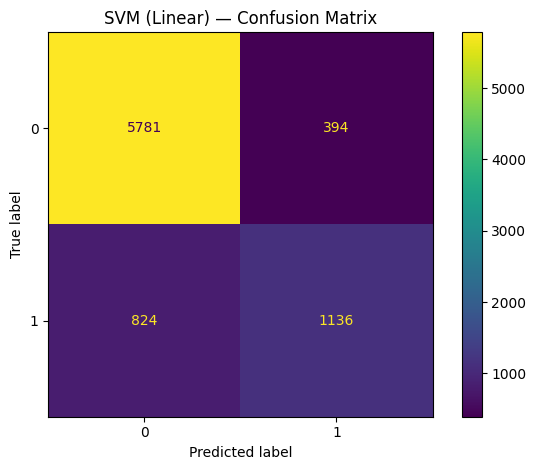

<Figure size 640x480 with 0 Axes>

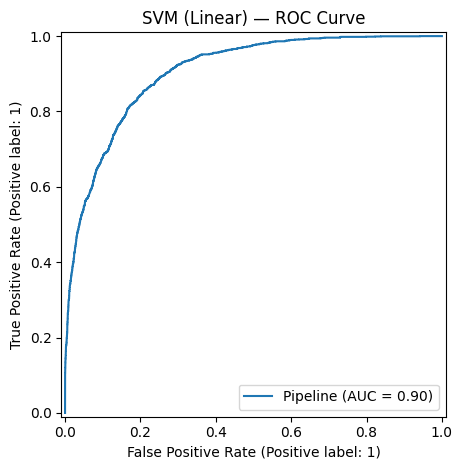

<Figure size 640x480 with 0 Axes>

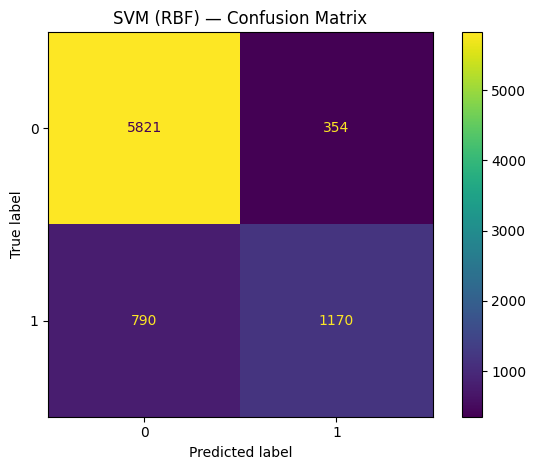

<Figure size 640x480 with 0 Axes>

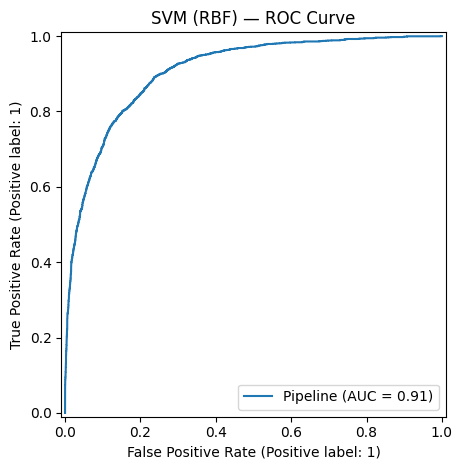

In [177]:
plt.figure()
ConfusionMatrixDisplay.from_estimator(svm_linear, X_test, y_test)
plt.title("SVM (Linear) — Confusion Matrix")
plt.tight_layout(); plt.show()

#Linear SVM - ROC
plt.figure()
RocCurveDisplay.from_estimator(svm_linear, X_test, y_test)
plt.title("SVM (Linear) — ROC Curve")
plt.tight_layout(); plt.show()

#RBF SVM - Confusion Matrix
plt.figure()
ConfusionMatrixDisplay.from_estimator(svm_rbf, X_test, y_test)
plt.title("SVM (RBF) — Confusion Matrix")
plt.tight_layout(); plt.show()

#RBF SVM - ROC
plt.figure()
RocCurveDisplay.from_estimator(svm_rbf, X_test, y_test)
plt.title("SVM (RBF) — ROC Curve")
plt.tight_layout(); plt.show()


#### Hyperparameters tuning

In [ ]:
svm_rbf_grid = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", SVC(kernel="rbf", probability=True, random_state=42))
])

param_grid_svm = {
    "clf__C": [0.1, 1, 10],
    "clf__gamma": ["scale", 0.01, 0.1]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
grid_svm = GridSearchCV(
    estimator=svm_rbf_grid,
    param_grid=param_grid_svm,
    scoring="roc_auc",
    cv=cv, n_jobs=-1
)

grid_svm.fit(X_train, y_train)
print("Best params (SVM-RBF):", grid_svm.best_params_)
print("Best CV ROC-AUC (SVM-RBF):", round(grid_svm.best_score_, 4))

best_svm_rbf = grid_svm.best_estimator_
from sklearn.metrics import roc_auc_score
test_auc = roc_auc_score(y_test, best_svm_rbf.predict_proba(X_test)[:, 1])
print("Test ROC-AUC (best SVM-RBF):", round(test_auc, 4))

#### Random Forest

In [178]:
rf = Pipeline(steps=[
    ("prep", preprocess),
    ("clf", RandomForestClassifier(
        n_estimators=300, max_depth=None, min_samples_leaf=2,
        random_state=42, class_weight="balanced_subsample"
    ))
])
rf.fit(X_train, y_train)

y_pred_rf = rf.predict(X_test)
y_prob_rf = rf.predict_proba(X_test)[:, 1]

rf_metrics = metric_summary(y_test, y_pred_rf, y_prob_rf)
pd.DataFrame([base_metrics, lr_metrics, rf_metrics],
             index=["Baseline","LogisticRegression","RandomForest"]).round(3)


,accuracy,precision,recall,f1,roc_auc,pr_auc
Baseline,0.759,0.000,0.000,0.000,0.50,0.241
LogisticRegression,0.809,0.568,0.858,0.684,0.91,0.773
RandomForest,0.834,0.613,0.843,0.710,0.92,0.803


#### ROC Curves and Precision Recall

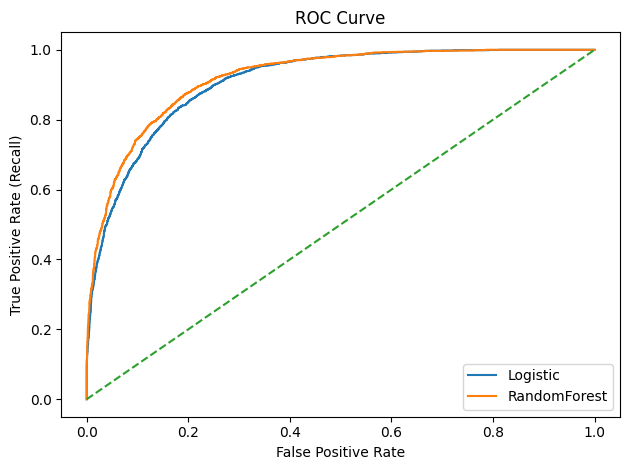

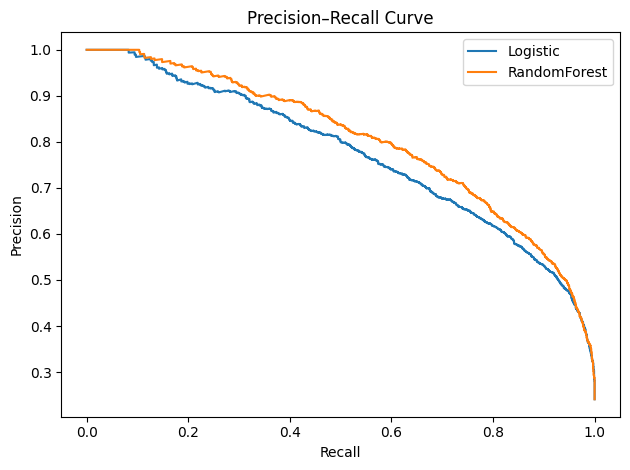

In [179]:
plt.figure()
for label, y_prob in [
    ("Logistic", y_prob_lr),
    ("RandomForest", y_prob_rf)
]:
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    plt.plot(fpr, tpr, label=f"{label}")
plt.plot([0,1],[0,1], linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate (Recall)")
plt.title("ROC Curve")
plt.legend()
plt.tight_layout()
plt.show()

plt.figure()
for label, y_prob in [
    ("Logistic", y_prob_lr),
    ("RandomForest", y_prob_rf)
]:
    prec, rec, _ = precision_recall_curve(y_test, y_prob)
    plt.plot(rec, prec, label=f"{label}")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.legend()
plt.tight_layout()
plt.show()


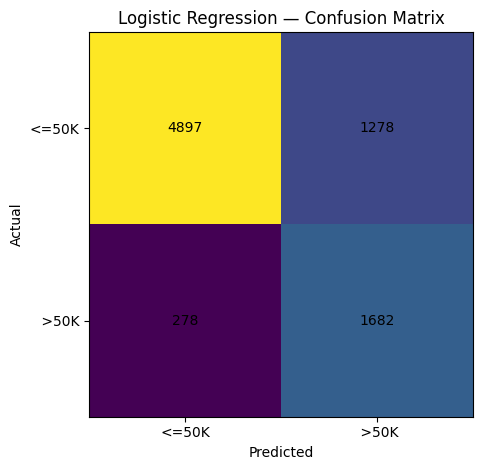

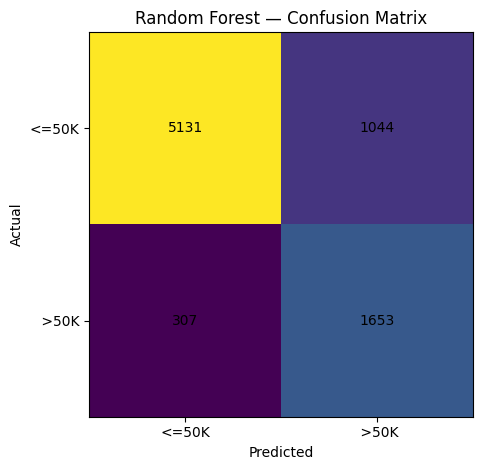

(array([[4897, 1278],
        [ 278, 1682]], dtype=int64),
 array([[5131, 1044],
        [ 307, 1653]], dtype=int64))

In [180]:
def plot_confusion(y_true, y_prob, threshold=0.5, title="Confusion Matrix"):
    y_pred = (y_prob >= threshold).astype(int)
    cm = confusion_matrix(y_true, y_pred)

    plt.figure()
    plt.imshow(cm, interpolation="nearest")
    plt.title(title)
    plt.xticks([0,1], ["<=50K"," >50K"])
    plt.yticks([0,1], ["<=50K"," >50K"])
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            plt.text(j, i, cm[i, j], ha="center", va="center")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()
    return cm

cm_lr = plot_confusion(y_test, y_prob_lr, 0.5, "Logistic Regression — Confusion Matrix")
cm_rf = plot_confusion(y_test, y_prob_rf, 0.5, "Random Forest — Confusion Matrix")
cm_lr, cm_rf


#### Cross validation (ROC-AUC & PR-AUC)

In [181]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

def cv_metrics(pipe, X, y, cv):
    roc = cross_val_score(pipe, X, y, cv=cv, scoring="roc_auc")
    pr  = cross_val_score(pipe, X, y, cv=cv, scoring="average_precision")
    return pd.Series({
        "ROC-AUC mean": roc.mean(), "ROC-AUC std": roc.std(),
        "PR-AUC mean": pr.mean(),   "PR-AUC std": pr.std()
    })

cv_lr = cv_metrics(log_reg, X, y, cv)
cv_rf = cv_metrics(rf, X, y, cv)
pd.DataFrame([cv_lr, cv_rf], index=["LogisticRegression","RandomForest"]).round(3)


,ROC-AUC mean,ROC-AUC std,PR-AUC mean,PR-AUC std
LogisticRegression,0.905,0.002,0.763,0.007
RandomForest,0.916,0.002,0.792,0.005


,feature,coef
3,capital-gain,2.209021
15,marital-status_Married-civ-spouse,1.425907
47,native-country_Cambodia,1.211263
14,marital-status_Married-AF-spouse,1.177699
39,relationship_Wife,1.132904
23,occupation_Exec-managerial,0.854998
1,education-num,0.765372
91,education_1st-4th,0.704266
32,occupation_Tech-support,0.698803
30,occupation_Protective-serv,0.698347


,feature,coef
28,occupation_Priv-house-serv,-1.704988
81,native-country_South,-1.387032
12,workclass_Without-pay,-1.170923
17,marital-status_Never-married,-1.081065
52,native-country_Dominican-Republic,-1.068629
50,native-country_Columbia,-1.056266
37,relationship_Own-child,-1.028096
24,occupation_Farming-fishing,-0.914412
45,sex_Female,-0.877836
101,education_Preschool,-0.841229


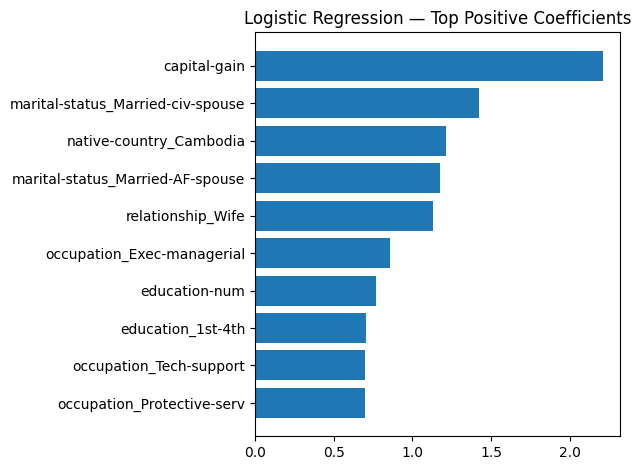

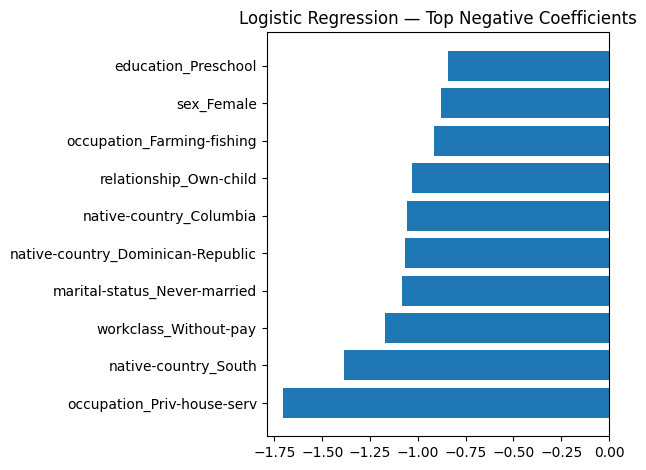

In [182]:
prep = log_reg.named_steps["prep"]
ohe = prep.named_transformers_["cat"].named_steps["onehot"]
num_names = num_features
cat_names = ohe.get_feature_names_out(cat_features).tolist()
feature_names = num_names + cat_names

coef = log_reg.named_steps["clf"].coef_[0]
coef_df = pd.DataFrame({"feature": feature_names, "coef": coef}).sort_values("coef", ascending=False)

top_pos = coef_df.head(10)
top_neg = coef_df.tail(10).sort_values("coef")

display(top_pos)
display(top_neg)

#Plotting top positive & negative coefficients
plt.figure()
plt.barh(top_pos["feature"][::-1], top_pos["coef"][::-1])
plt.title("Logistic Regression — Top Positive Coefficients")
plt.tight_layout()
plt.show()

plt.figure()
plt.barh(top_neg["feature"], top_neg["coef"])
plt.title("Logistic Regression — Top Negative Coefficients")
plt.tight_layout()
plt.show()


#### Random Forest feature importance

,feature,importance
0,age,0.123523
15,marital-status_Married-civ-spouse,0.116299
1,education-num,0.092746
34,relationship_Husband,0.087675
3,capital-gain,0.086159
2,hours-per-week,0.067159
17,marital-status_Never-married,0.062300
37,relationship_Own-child,0.028299
4,capital-loss,0.022389
35,relationship_Not-in-family,0.021977


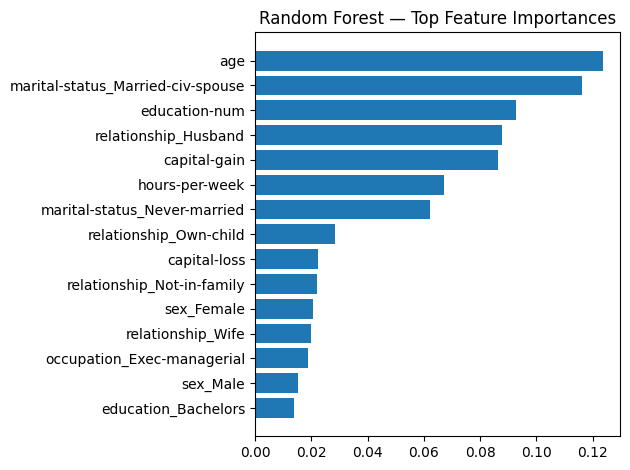

In [183]:
rf_clf = rf.named_steps["clf"]
rf_importances = rf_clf.feature_importances_
fi_df = pd.DataFrame({"feature": feature_names, "importance": rf_importances}).sort_values("importance", ascending=False)

fi_top = fi_df.head(15)
display(fi_top)

plt.figure()
plt.barh(fi_top["feature"][::-1], fi_top["importance"][::-1])
plt.title("Random Forest — Top Feature Importances")
plt.tight_layout()
plt.show()


#### Model Comparison

In [184]:
comparison = pd.DataFrame(
    [
        {"model":"LogisticRegression", **lr_metrics},
        {"model":"RandomForest", **rf_metrics},
        {"model":"SVM-Linear", **svm_lin_metrics},
        {"model":"SVM-RBF", **svm_rbf_metrics},
    ]
).set_index("model").round(3)

print("Test Set Metrics")
display(comparison)

best = comparison.sort_values("pr_auc", ascending=False).iloc[0]
print(f"\nBest by PR-AUC: {best.name} (PR-AUC={best['pr_auc']:.3f}, ROC-AUC={best['roc_auc']:.3f})")



Test Set Metrics


,accuracy,precision,recall,f1,roc_auc,pr_auc
model,,,,,,
LogisticRegression,0.809,0.568,0.858,0.684,0.910,0.773
RandomForest,0.834,0.613,0.843,0.710,0.920,0.803
SVM-Linear,0.850,0.742,0.580,0.651,0.904,0.770
SVM-RBF,0.859,0.768,0.597,0.672,0.907,0.780



Best by PR-AUC: RandomForest (PR-AUC=0.803, ROC-AUC=0.920)


#### Part 4 - Deep learning and Neural-Networks

In [185]:
from tensorflow import keras
from tensorflow.keras import layers, callbacks, regularizers

#### Prepare features (train/val/test) and make Keras-ready arrays

In [186]:
y = df_feat["high_income"]
num_cols = [c for c in ["age","education-num","hours-per-week","capital-gain","capital-loss"] if c in df_feat.columns]
cat_cols = [c for c in ["workclass","marital-status","occupation","relationship","race","sex","native-country","education"] if c in df_feat.columns]

X = df_feat[num_cols + cat_cols].copy()

#split: train / temp, then temp -> val/test (so we have an explicit validation set for callbacks)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.30, random_state=42, stratify=y)
X_val,   X_test, y_val, y_test   = train_test_split(X_temp, y_temp, test_size=0.50, random_state=42, stratify=y_temp)

#ColumnTransformer: scale numerics, one-hot categoricals
preprocess = ColumnTransformer([
    ("num", StandardScaler(), num_cols),
    ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
], remainder="drop")

#fit on TRAIN only, then transform all splits
X_train_s = preprocess.fit_transform(X_train)
X_val_s   = preprocess.transform(X_val)
X_test_s  = preprocess.transform(X_test)

#dimension for Keras dense net
input_dim = X_train_s.shape[1]
input_dim, X_train_s.shape, X_val_s.shape, X_test_s.shape

(104, (22775, 104), (4881, 104), (4881, 104))

#### Define a simple, regularized MLP

In [187]:
def build_mlp(input_dim, l2=1e-4, dropout=0.2, lr=1e-3):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(64, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        layers.Dropout(dropout),
        layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(l2)),
        layers.Dropout(dropout),
        layers.Dense(1, activation='sigmoid')
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss='binary_crossentropy',
        metrics=['accuracy', keras.metrics.AUC(name='auc')]
    )
    return model

mlp = build_mlp(input_dim)
mlp.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_9 (Dense)                 │ (None, 64)             │         6,720 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 8,833 (34.50 KB)

 Trainable params: 8,833 (34.50 KB)

 Non-trainable params: 0 (0.00 B)

#### Callbacks (EarlyStopping + ModelCheckpoint) and trainin

In [188]:
ckpt_path = "best_mlp.keras"
cbs = [
    callbacks.EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss'),
    callbacks.ModelCheckpoint(ckpt_path, save_best_only=True, monitor='val_loss')
]

hist = mlp.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=100,
    batch_size=32,
    callbacks=cbs,
    verbose=0
)

print("Best val loss:", float(np.min(hist.history['val_loss'])))


Best val loss: 0.3067515790462494


#### Test evaluation (Accuracy, AUC) + PR-AUC

In [189]:
test_dict = mlp.evaluate(X_test_s, y_test, return_dict=True, verbose=0)
y_prob = mlp.predict(X_test_s, verbose=0).ravel()
test_pr_auc = average_precision_score(y_test, y_prob)

print({
    "loss": round(float(test_dict["loss"]), 6),
    "accuracy": round(float(test_dict["accuracy"]), 3),
    "auc": round(float(test_dict["auc"]), 3),
    "pr_auc": round(float(test_pr_auc), 3)
})


{'loss': 0.310346, 'accuracy': 0.859, 'auc': 0.916, 'pr_auc': 0.793}


#### Learning curve plot

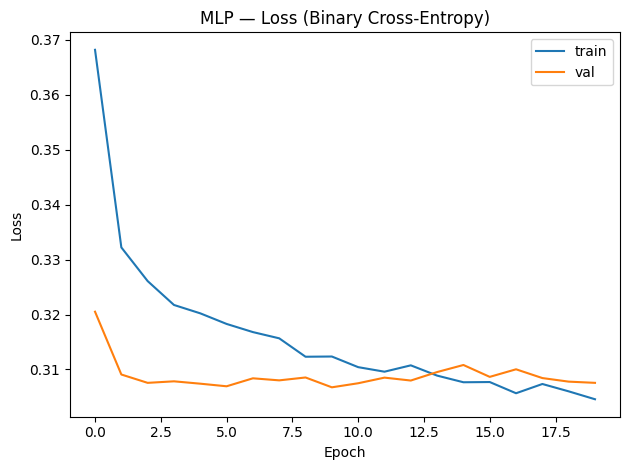

In [190]:
plt.figure()
plt.plot(hist.history["loss"], label="train")
plt.plot(hist.history["val_loss"], label="val")
plt.title("MLP — Loss (Binary Cross-Entropy)")
plt.xlabel("Epoch"); plt.ylabel("Loss"); plt.legend(); plt.tight_layout(); plt.show()

#### Threshold tuning and confusion matrix

{'best_threshold': 0.352, 'precision': 0.65, 'recall': 0.787, 'f1': 0.712}


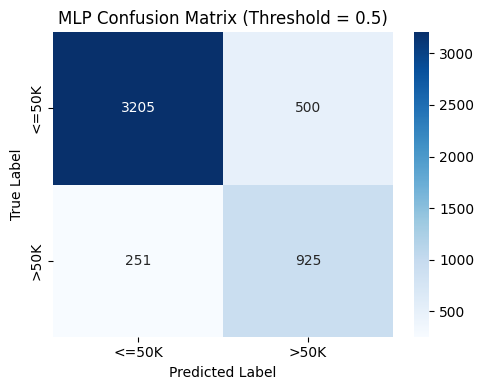

In [191]:
prec, rec, thr = precision_recall_curve(y_test, y_prob)
thr = np.r_[0, thr]  #align lengths
f1 = 2 * (prec * rec) / (prec + rec + 1e-12)
best_idx = int(np.nanargmax(f1))
best_thr = float(thr[best_idx])

y_pred = (y_prob >= best_thr).astype(int)
cm = confusion_matrix(y_test, y_pred)
labels = ["<=50K", ">50K"]

print({"best_threshold": round(best_thr, 3),
       "precision": round(float(prec[best_idx]), 3),
       "recall": round(float(rec[best_idx]), 3),
       "f1": round(float(f1[best_idx]), 3)})
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=labels, yticklabels=labels)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("MLP Confusion Matrix (Threshold = 0.5)")
plt.tight_layout()
plt.show()


## Report

### Executive Summary
We analyzed the Adult Income dataset to identify which demographic and occupational factors are associated with earning more than $50,000 annually. After cleaning and preparing the data, we validated our hypotheses using appropriate statistical tests and developed predictive models, Logistic Regression, Random Forest, and two Support Vector Machine (SVM) variants (Linear and RBF).

All models performed strongly, with ROC-AUC values between 0.90–0.92 and PR-AUC between 0.77–0.80, indicating that demographic and work-related variables provide meaningful predictive power. Consistent signals emerged across models: education level, marital status (being married), hours worked per week, age, and capital gains were the most informative predictors of high income.

### Methods

Data Preparation:
Missing entries (“?”) were replaced with NaN. Categorical features were imputed using their mode, and numeric features were imputed with the median to minimize the influence of outliers. Duplicate records were removed. New binary variables were created to indicate the presence of capital gains or losses, and a high_income target variable was derived (> $50K = 1). Rare categories (less than 1%) were collapsed into an “Other” group to reduce sparsity and improve model stability.

Exploration & Visualization:
EDA included visualizations of the high-income rate by education-num (ordered), marital status, and occupation, as well as histograms comparing hours worked per week across income groups. Correlation heatmaps and pivot tables were used to reveal relationships among variables.

Statistical Testing:

- T-test for hours-per-week confirmed that >$50K earners work significantly longer hours.

- Chi-square tests for marital-status, occupation, and capital-gain confirmed statistically significant relationships with income category.

Predictive Modeling:

- Logistic Regression: Provided interpretable coefficients to quantify direction and strength of predictors.

- Random Forest: Captured non-linear interactions and variable importance.

- SVM (Linear & RBF): Evaluated for margin-based separation and kernelized pattern detection, following the professor’s module 3 methodology.
Each model was evaluated on accuracy, precision, recall, F1-score, ROC-AUC, and PR-AUC to account for class imbalance (only ~24% earn >$50K).

### Results of Hypothesis Testing

H1 (Education): Supported. </br>
Why/How: High-income rate rises monotonically with education-num in the ordered bar plot; in models, education has a positive logistic coefficient and high RF importance.</br>
So what: More education is consistently associated with higher odds of >$50K.</br>
</br>
H2 (Work hours): Supported.</br>
Why/How: A t-test shows >$50K earners work significantly more hours/week; partial-dependence for hours/week slopes upward; both models weight this feature.</br>
So what: Additional weekly hours are linked to higher income probability.</br>
</br>
H3 (Marital status): Supported.</br>
Why/How: Chi-square shows high-income rates differ by marital status; “Married-civ-spouse” has strong positive signal (positive coefficient; top importances), while “Never-married” is negative.</br>
So what: Marital status captures meaningful socioeconomic context related to income.</br>
</br>
H4 (Occupation): Partially supported (heterogeneous effects).</br>
Why/How: Chi-square confirms differences across occupations; Exec-managerial/Tech-support skew higher; Priv-house-serv/Farming-fishing skew lower. Model coefficients/importance reflect these patterns.</br>
So what: Occupation meaningfully segments income likelihood.</br>
</br>
H5 (Capital gains): Supported.</br>
Why/How: Chi-square for any capital gains vs high income is significant; capital-gain is among the strongest predictors (largest positive logistic coefficient; high RF importance).</br>
So what: Reporting capital gains strongly increases predicted odds of >$50K.

### Model performance and Predictive Value


Interpretability:

- The SVM-RBF achieved the highest accuracy (0.859) and a competitive PR-AUC (0.780), slightly outperforming Random Forest in overall balanced accuracy.

- The SVM-Linear model achieved the best precision (0.742), suggesting it’s most conservative—fewer false positives when predicting >$50K earners.

- Random Forest maintained the best recall–precision balance (PR-AUC = 0.803) and remains the strongest model for ranking or prioritization tasks.

- Logistic Regression remains valuable for interpretability: coefficients show capital-gain, education-num, and married status positively influence the odds of high income, while never-married and low-skill occupations are negative predictors.

High ROC-AUC (0.90+) across all models confirms strong ranking ability, and PR-AUC near 0.80 indicates effective handling of the imbalanced target. Confusion matrix plots show that while recall varies slightly, all models perform consistently on the majority and minority classes.

##### Why These Results Matter

The results confirm that income can be meaningfully predicted using demographic and occupational features.

The strong and consistent relationships across methods provide analytical confidence.

SVM models add robustness, showing that the separation between income classes is both linearly and non-linearly discernible.

These models could be used for population segmentation, exploratory socioeconomic studies, or to design interventions targeting educational or occupational advancement.

#### Applying and Interpreting Results

##### Connecting Results to the Problem Statement

The original objective of this project was to determine which demographic and work-related variables most strongly influence whether an individual earns more than $50,000 per year. The results from our statistical tests and predictive modeling directly address this question by identifying and quantifying the impact of factors such as education, marital status, occupation, hours worked, and capital gains on income level.

Each model, Logistic Regression, Random Forest, and both SVM variants converged on the same set of high-importance predictors, providing robust evidence that these variables are meaningful and consistent indicators of economic outcomes. This convergence increases confidence that the observed relationships are not model-specific artifacts but reflect true underlying patterns in the data.

##### Practical Implications and Application

1. Educational and Workforce Planning:
The clear positive relationship between education level and income highlights the tangible financial benefit of advanced education or skill development. Policymakers, educational institutions, and workforce development programs can use this evidence to design initiatives that improve access to higher education and professional training, particularly for underrepresented groups.

2. Employment and Labor Insights:
Employers and HR departments can use these insights to understand compensation trends across occupations and work hours. For instance, managerial, technical, and protective-service occupations consistently correlate with higher earnings. This can guide targeted recruitment, upskilling programs, and compensation benchmarking.

3. Socioeconomic Policy Considerations:
The strong association between marital status and income suggests that socioeconomic stability and family support structures may play a role in financial outcomes. Community-level policies that strengthen household stability and economic resilience could indirectly influence income equity.

4. Predictive Use Cases:
The trained models, particularly the Random Forest and SVM-RBF, could be operationalized to estimate an individual’s likelihood of earning above a specific income threshold based on demographic or employment data. This could support forecasting, segmentation, or policy simulations in labor economics and social analytics contexts.

##### Actionable Takeaways

Invest in education and skills. Increasing educational attainment has a direct, measurable impact on income potential.

Policies that encourage stable employment and full-time work participation align with the observed correlation between hours worked and higher earnings.

Prioritize data-driven decisions. Organizations and agencies can use models like these to identify at-risk populations, forecast workforce outcomes, and allocate training or financial resources more effectively.

Balance fairness with predictive power. Before applying the model for individual-level predictions, fairness and bias analyses should be conducted, particularly across sensitive features such as race and gender.

##### Conclusion

By integrating the results into practical action, this analysis transforms from an academic exercise into a foundation for data-informed decision-making. The combination of interpretable (Logistic Regression) and high-performing (Random Forest, SVM-RBF) models provides both transparency and predictive strength enable stakeholders to make evidence-based choices about education, employment, and policy aimed at promoting income growth.

### Next Steps

- Model Calibration: Apply isotonic or Platt scaling if predicted probabilities are used for policy or decision thresholds.

- Feature Refinement: Drop or consolidate sparse features (e.g., native-country) to improve stability and runtime.

- Explainability: Use SHAP or partial dependence plots for model interpretability, especially for SVM and Random Forest.

- Fairness Checks: Assess performance across sensitive attributes (gender, race) to ensure ethical use.

- Extensions: Experiment with gradient boosting or tuned RBF kernels; add interaction terms like education × occupation.